In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

import sys
import numpy as np

import scipy.stats as spstats
from scipy.spatial.distance import pdist

from sklearn.metrics import roc_curve, roc_auc_score

from collections import Counter

sys.path.append("..")
from analysis.validation.evaluate_AUC import get_contactmap

In [2]:
def create_physical_map(coords, p_resolution, bins):
    
    m_bins, n_bins = bins, bins
    datum_physical = -np.ones((m_bins, n_bins))
    for i in range(len(coords[:,0])):
        for j in range(i):
            t = i #int(coords[i,0])-1
            u = j #int(coords[j,0])-1

            if (t%p_resolution == 0) and (u%p_resolution == 0):

                x, y = t//p_resolution, u//p_resolution
                d = pdist([coords[i,:], coords[j,:]])[0]
                try:
                    datum_physical[x,y] = d
                    datum_physical[y,x] = d
                except IndexError:
                    pass
    return datum_physical

def create_binary_map(coords, p_resolution, bins, k, p_mean_u,
                      lower_pct_threshold=0.1,
                      upper_pct_threshold=0.9, is_angstrom=False):
    
    m_bins, n_bins = bins, bins
    datum_binary = np.zeros((m_bins, n_bins))
    for i in range(len(coords[:,0])):
        for j in range(i):
            t = i #int(coords[i,0])-1
            u = j #int(coords[j,0])-1

            if (t%p_resolution == 0) and (u%p_resolution == 0):

                x, y = t//p_resolution, u//p_resolution
                d = pdist([coords[i,:], coords[j,:]])[0]

                # this distance, d, is in nm instead of angstrom
                # need to multiply by 10
                if is_angstrom:
                    percentile = spstats.gamma.cdf(d, a=k, scale=p_mean_u/k)
                else:
                    percentile = spstats.gamma.cdf(d*10, a=k, scale=p_mean_u/k)
                
                if percentile > lower_pct_threshold and percentile < upper_pct_threshold:

                    try:
                        datum_binary[x,y] = 1
                        datum_binary[y,x] = 1
                    except IndexError:
                        pass

    return datum_binary

### EEF1G 3D Structure (Simulated)

In [4]:
f_coords = "../analysis/structure/final/NM_001404_coords.txt"
coords = np.loadtxt(f_coords)

In [5]:
p_resolution = 1
bins = (len(coords)//p_resolution)+1

datum_physical = create_physical_map(coords, p_resolution, bins)

Text(0.5, 1.0, 'EEF1G\n3D structure (simulated)')

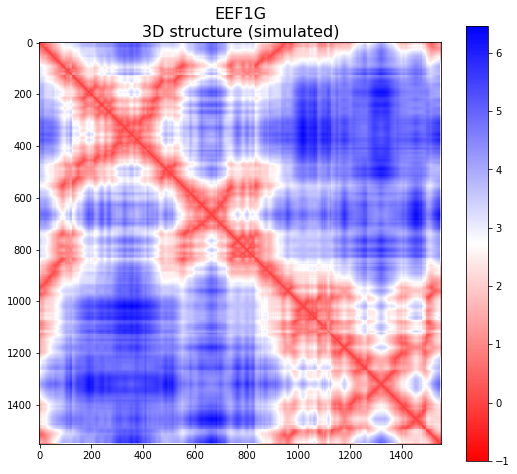

In [13]:
plt.figure(figsize=(9, 8))
plt.imshow(datum_physical, cmap="bwr_r")
plt.colorbar()
plt.title("EEF1G\n3D structure (simulated)", fontsize=16)

### Estimating AUC
#### Contact Map and Physical Distance Map at various resolutions

In [15]:
f_pairs = ["../../data/star/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HepG2-refold_M13_R01.dedup.pairs.gz", "../../data/star/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HepG2-refold_M13_R02.dedup.pairs.gz"]

f_pairs += ["../../data/star/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-K562-refold_M15_R01.dedup.pairs.gz", "../../data/star/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-K562-refold_M15_R02.dedup.pairs.gz"]

f_pairs += ["../../data/star/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HEK293T-refold_M15_R01.dedup.pairs.gz", "../../data/star/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HEK293T-refold_M15_R02.dedup.pairs.gz"]

In [16]:
f_coords = "../analysis/structure/final/NM_001404_coords.txt"
coords = np.loadtxt(f_coords)

(63, 63) (63, 63) 63
Counter({0.0: 2661, 1.0: 1308})
0.6345678014432814
(32, 32) (32, 32) 32
Counter({0.0: 682, 1.0: 342})
0.6567153177060299
(16, 16) (16, 16) 16
Counter({0.0: 178, 1.0: 78})
0.6794871794871795


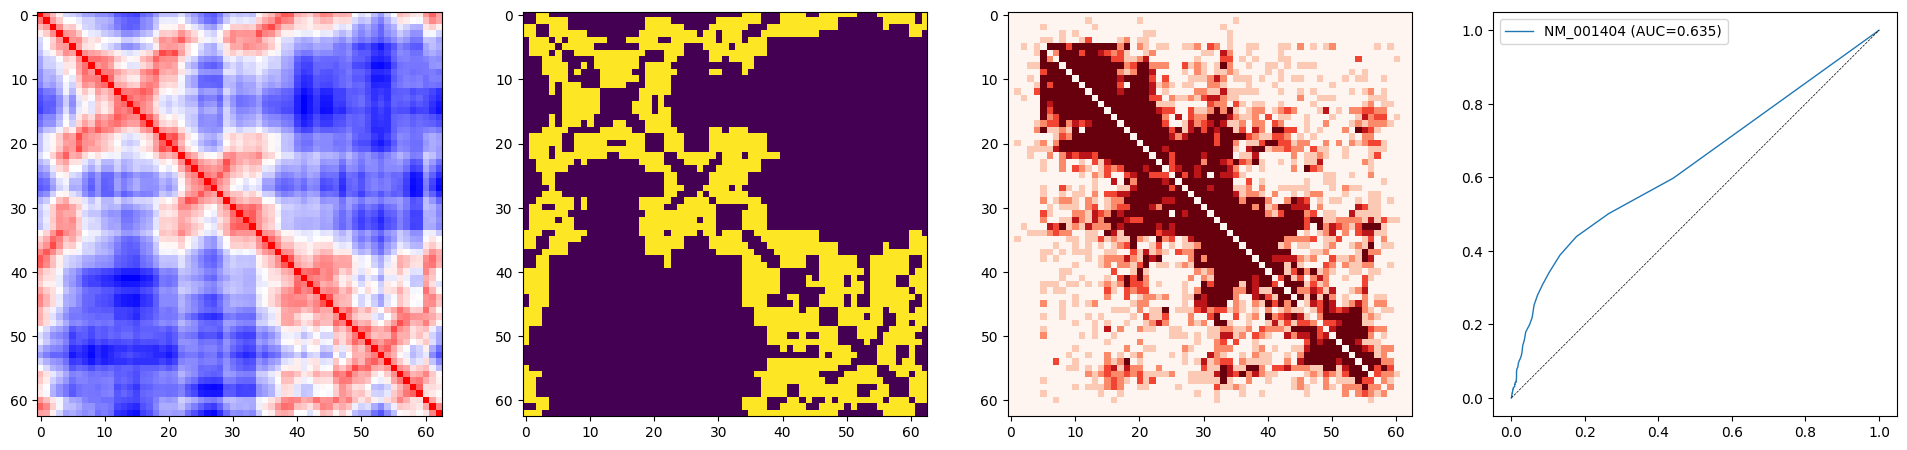

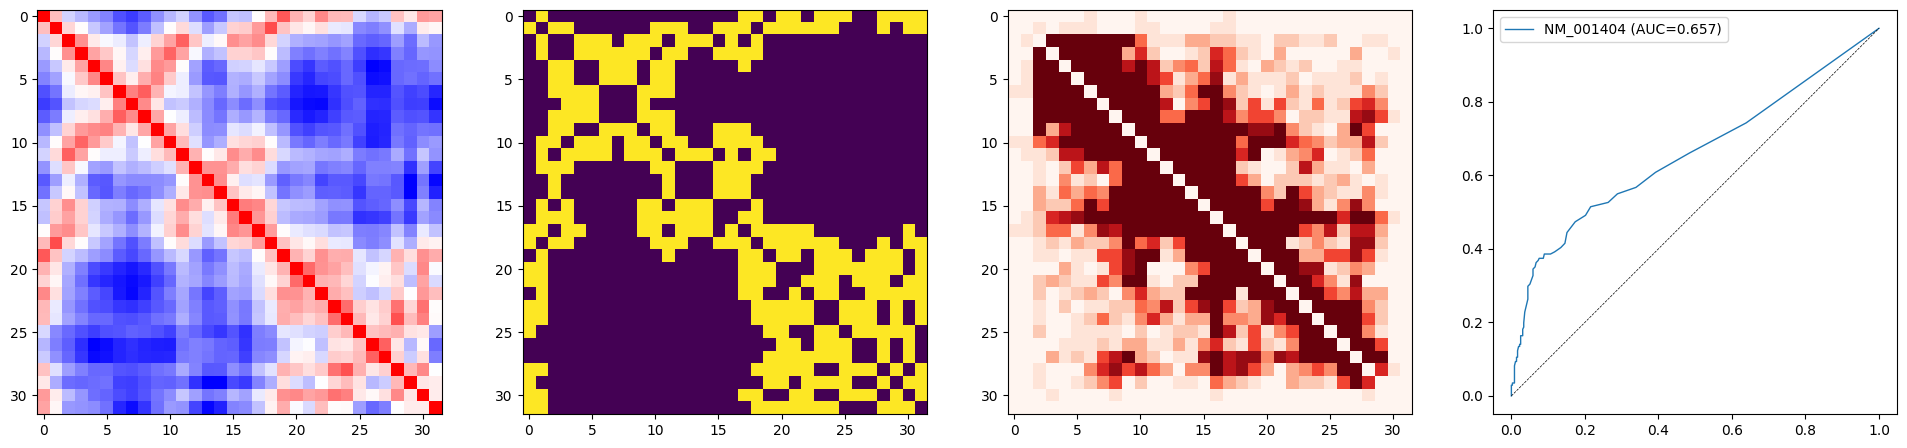

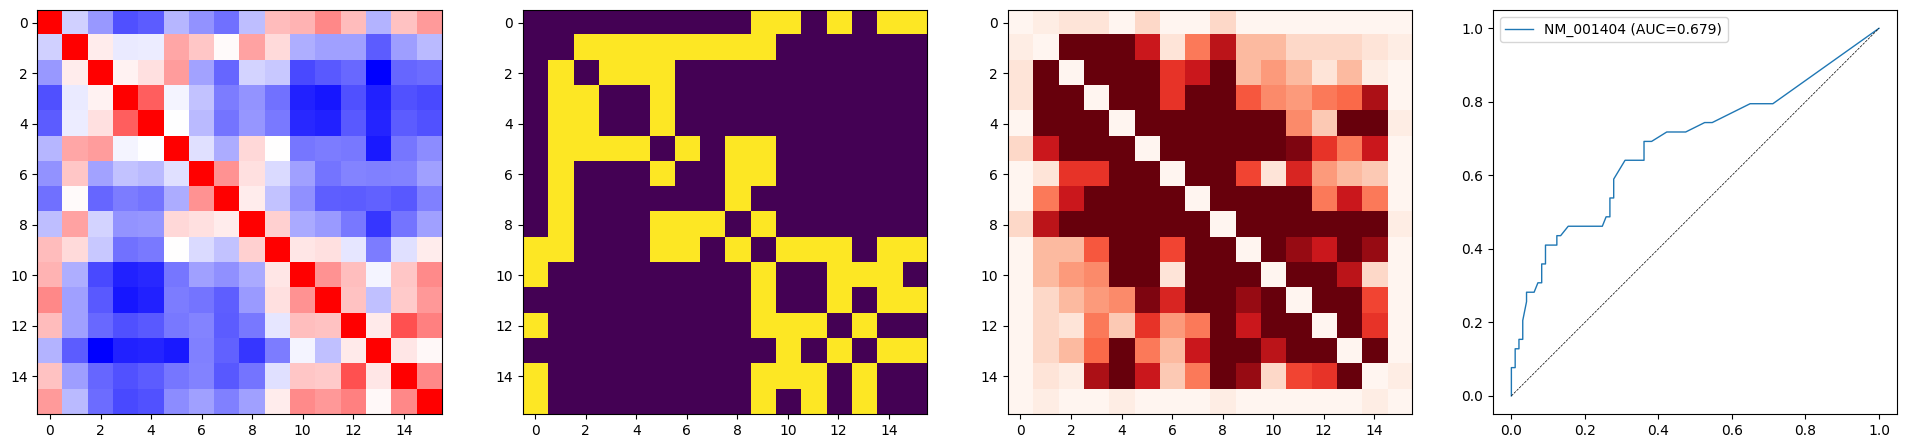

In [18]:
p_genome = "hg19"
p_chrom1 = "NM_001404"

p_resolutions = [25, 50, 100]
p_depths = [5, 10, 20]

for p_resolution, p_depth in zip(p_resolutions, p_depths):

    bins = (len(coords)//p_resolution)+1

    datum_physical = create_physical_map(coords, p_resolution, bins)
    datum_binary = create_binary_map(coords, p_resolution, bins, 6, 20,
                                    lower_pct_threshold=0.1,
                                    upper_pct_threshold=0.9)

    raw = get_contactmap(f_pairs, p_chrom1=p_chrom1,
                        p_resolution=p_resolution, p_genome=p_genome)
    datum = raw[0]

    print(datum.shape, datum_binary.shape, bins)

    # remove diagonal
    idiag = np.diag_indices(bins-1)
    datum[idiag] = 0

    iut = np.triu_indices(bins)
    assay_counts = datum[iut]
    assay_truths = datum_binary[iut]

    print(Counter(datum_binary.flatten()))


    fig, ax = plt.subplots(1, 4, figsize=(24, 6), dpi=100)
    ax[0].imshow(datum_physical, cmap="bwr_r")
    #ax[0].colorbar()
    ax[1].imshow(datum_binary, cmap="viridis")
    #ax[1].colorbar()
    ax[2].imshow(datum, cmap="Reds", vmin=0, vmax=p_depth)


    auc = roc_auc_score(assay_truths, assay_counts)
    fpr, tpr, thresholds = roc_curve(assay_truths, assay_counts)
    p_label = p_chrom1

    print(auc)
    ax[3].plot(fpr, tpr, linestyle="-", linewidth=1.0,
            label="%s (AUC=%.3f)" % (p_label, auc))
    ax[3].plot([0, 1], [0, 1], linestyle="--", linewidth=0.5, color="black")
    ax[3].legend()
    ax[3].set_aspect(1)